In [3]:
import numpy as np

from scipy.io import wavfile
from scipy.signal import stft

import matplotlib.pyplot as plt

import librosa

import align



In [4]:
def vcc2016filename(speaker=0, audio=1):
    assert 1 <= audio <= 162
    speakers = ['SF1', 'SF2', 'SF3', 'SM1', 'SM2',
                'TF1', 'TF2', 'TM1', 'TM2', 'TM3']
    return ('datasets/vcc2016/vcc2016_training/' + speakers[speaker] + '/'
            + str(100000 + audio) + '.wav')


sr1, v1 = wavfile.read(vcc2016filename(0, 1))
sr2, v2 = wavfile.read(vcc2016filename(3, 1))
assert sr1 == sr2 and len(v1.shape) == 1 and len(v2.shape) == 1
sr = sr1
v1 = v1.astype(np.float64)
v2 = v2.astype(np.float64)

In [5]:
def sound(x, rate=sr, label=''):
    from IPython.display import display, Audio, HTML
    display(HTML(
        '<style> table, th, td {border: 0px; }</style> <table><tr><td>'
        + label + '</td><td>' + Audio(x, rate=rate)._repr_html_()[3:]
        + '</td></tr></table>'
    ))


sound(v1)

sound(v2)

""


""


In [6]:
N_FFT = 2048
_, _, zxx1 = stft(v1, sr, nperseg=N_FFT)
_, _, zxx2 = stft(v2, sr, nperseg=N_FFT)
amp1 = np.abs(zxx1)
amp2 = np.abs(zxx2)
mfcc1 = librosa.feature.mfcc(v1, sr, n_mfcc=20,
                             n_fft=N_FFT, hop_length=N_FFT // 2)
mfcc2 = librosa.feature.mfcc(v2, sr, n_mfcc=20,
                             n_fft=N_FFT, hop_length=N_FFT // 2)

In [7]:
v1_recon = librosa.feature.inverse.griffinlim(
    amp1, hop_length=N_FFT // 2, win_length=N_FFT,
    n_iter=500)
sound(v1)
sound(v1_recon)

""


""


In [8]:
aligned_list = align.dtw_align(mfcc1, mfcc2)

In [9]:
# align using a's time
aligned_b = [0] * amp1.shape[1]
for i, j in aligned_list:
    aligned_b[i] = j
amp2_aligned = amp2[:, aligned_b]

In [10]:
v2_aligned = librosa.feature.inverse.griffinlim(
    amp2_aligned, hop_length=N_FFT // 2, win_length=N_FFT,
    n_iter=500)

sound(v2_aligned)

""


""


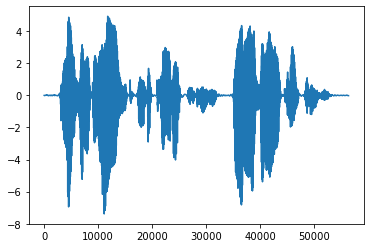

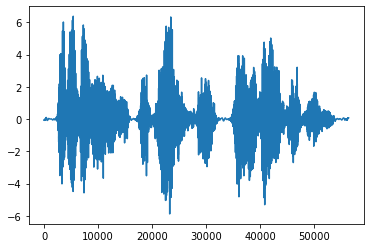

In [11]:
plt.figure()
plt.plot(v1 / np.sqrt(np.mean(v1 ** 2)))
plt.figure()
plt.plot(v2_aligned / np.sqrt(np.mean(v2_aligned ** 2)))

v = np.zeros(max(v1.size, v2_aligned.size))
v[:v1.size] += v1 / np.sqrt(np.mean(v1 ** 2))
v[:v2_aligned.size] += v2_aligned / np.sqrt(np.mean(v2_aligned ** 2))
sound(v)

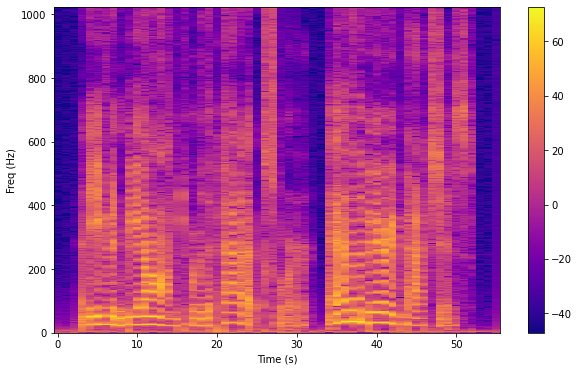

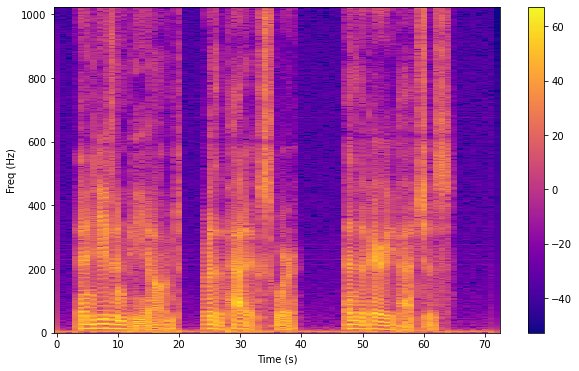

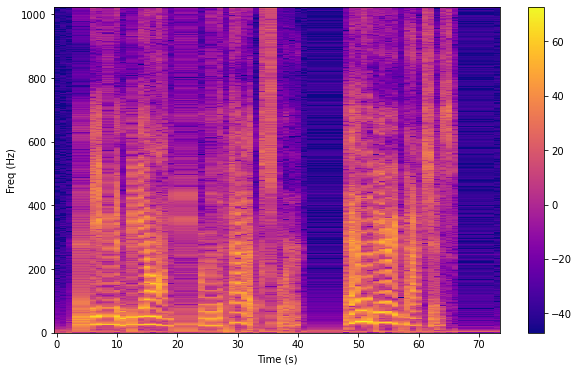

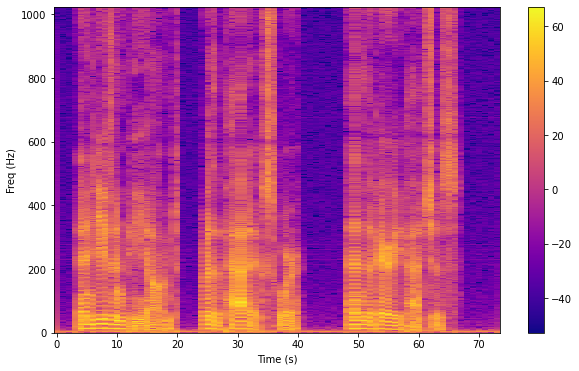

In [12]:
aligned_source, aligned_target = zip(*aligned_list)
from transform import log_stft
from visualization import plot_spec
log_amp1, log_amp2 = log_stft(amp1), log_stft(amp2)
plot_spec(log_amp1[:, ])
plot_spec(log_amp2[:, ])

plot_spec(log_amp1[:, aligned_source])
plot_spec(log_amp2[:, aligned_target])
